# AI-Powered Heart Disease Prediction System

In [1]:
!pip install shap
!pip install lime

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import shap
import lime
import lime.lime_tabular

## Load the dataset

In [2]:
data_path = 'HeartDisease.csv'
data = pd.read_csv(data_path)

In [3]:
# Display the first few rows to understand the structure of the dataset
print("Dataset Preview:")
print(data.head())

Dataset Preview:
   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                   

# Data Cleaning and Preprocessing

In [4]:
data.shape

(1025, 14)

In [5]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure           0
cholestoral                      0
fasting_blood_sugar              0
rest_ecg                         0
Max_heart_rate                   0
exercise_induced_angina          0
oldpeak                          0
slope                            0
vessels_colored_by_flourosopy    0
thalassemia                      0
target                           0
dtype: int64


In [6]:
X = data.drop('target', axis=1)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

### Pipeline for Numerical Data Preprocessing

In [7]:
# Imputers for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

### Pipeline for Categorical Data Preprocessing

In [8]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None))
])

In [9]:
# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Splitting the Data

In [10]:
X = data.drop('target', axis=1)
y = data['target']

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing the Data

In [12]:
# Fit and transform the training data, transform the test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [13]:
# Save the preprocessed data
print("\nPreprocessing Complete:")
print("Training data shape:", X_train_preprocessed.shape)
print("Testing data shape:", X_test_preprocessed.shape)


Preprocessing Complete:
Training data shape: (820, 30)
Testing data shape: (205, 30)


# Exploratory Data Analysis (EDA)

In [14]:
#Basic Statistics and Distributions
print("\nBasic Statistics:")
print(data.describe())


Basic Statistics:
               age  resting_blood_pressure  cholestoral  Max_heart_rate  \
count  1025.000000             1025.000000   1025.00000     1025.000000   
mean     54.434146              131.611707    246.00000      149.114146   
std       9.072290               17.516718     51.59251       23.005724   
min      29.000000               94.000000    126.00000       71.000000   
25%      48.000000              120.000000    211.00000      132.000000   
50%      56.000000              130.000000    240.00000      152.000000   
75%      61.000000              140.000000    275.00000      166.000000   
max      77.000000              200.000000    564.00000      202.000000   

           oldpeak       target  
count  1025.000000  1025.000000  
mean      1.071512     0.513171  
std       1.175053     0.500070  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.800000     1.000000  
75%       1.800000     1.000000  
max       6.200000     1.000000  

## Visualizing the distribution of numerical features

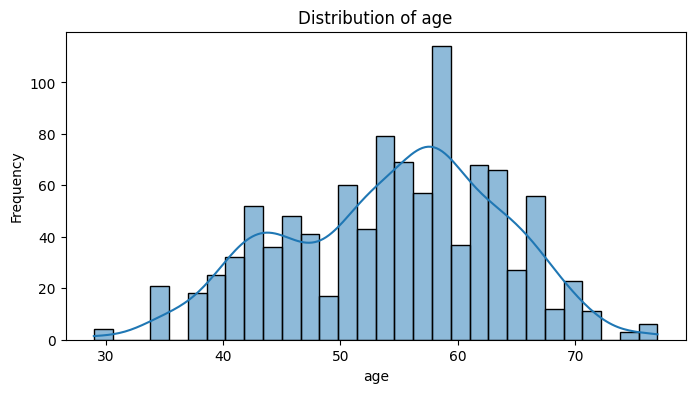

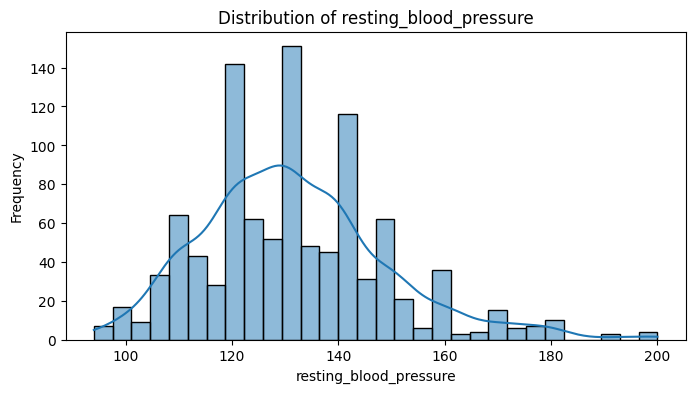

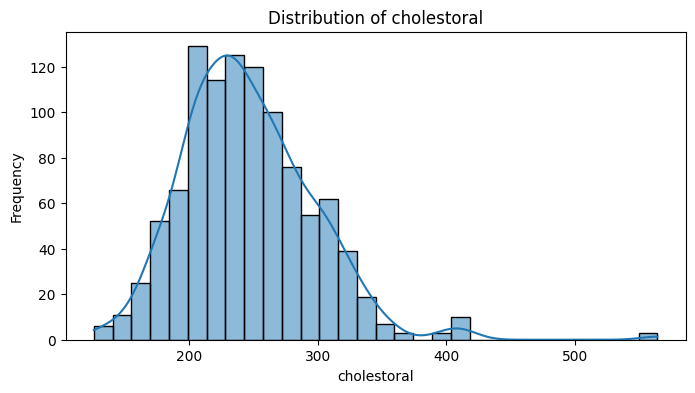

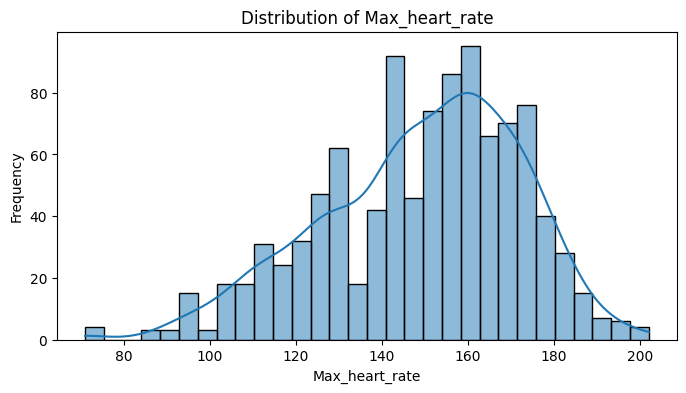

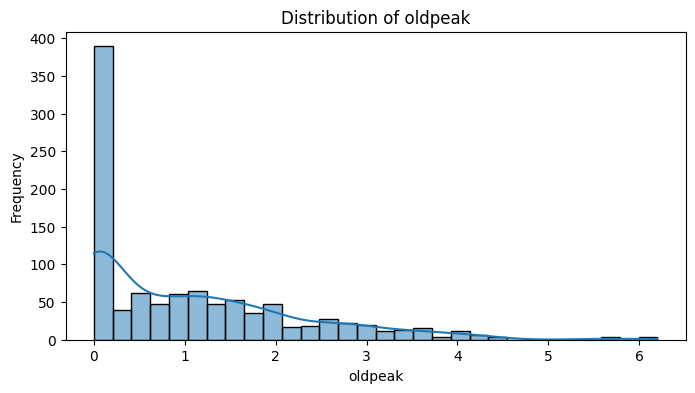

In [15]:

for column in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

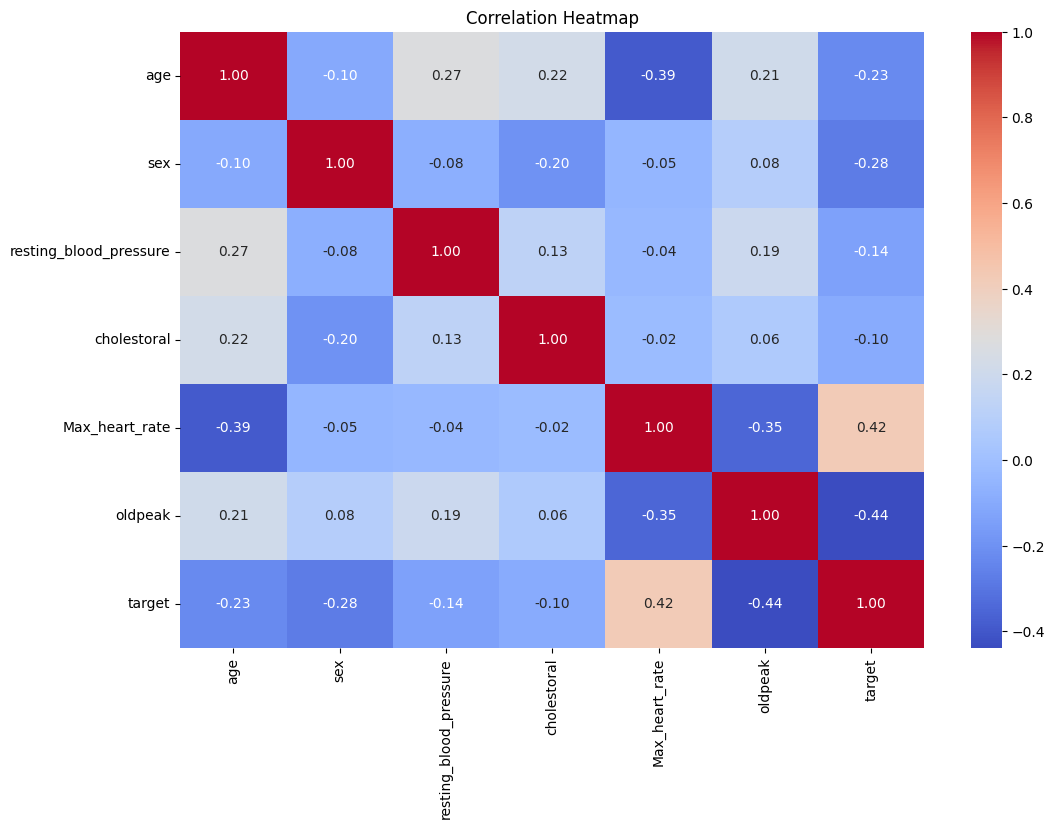

In [16]:
# Ensure 'sex' is explicitly converted to numeric
data['sex'] = data['sex'].map({'Male': 1, 'Female': 0})  # Convert categorical values to numerical


# Now, recalculate correlation
numeric_data = data.select_dtypes(include=['number'])  # Ensure numeric columns only
correlation_matrix = numeric_data.corr()

# Plot heatmap again
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


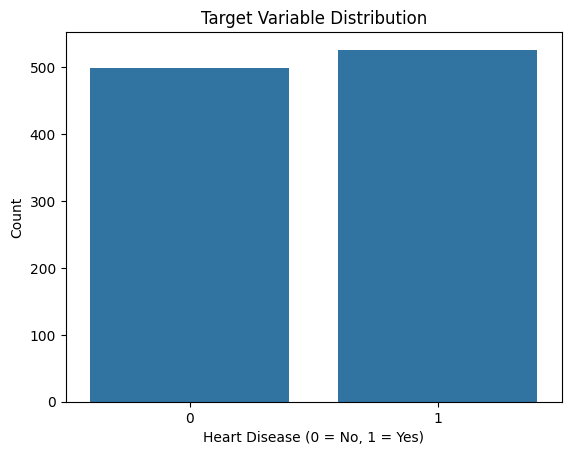

In [17]:
#Target Variable Analysis
sns.countplot(x='target', data=data)
plt.title('Target Variable Distribution')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

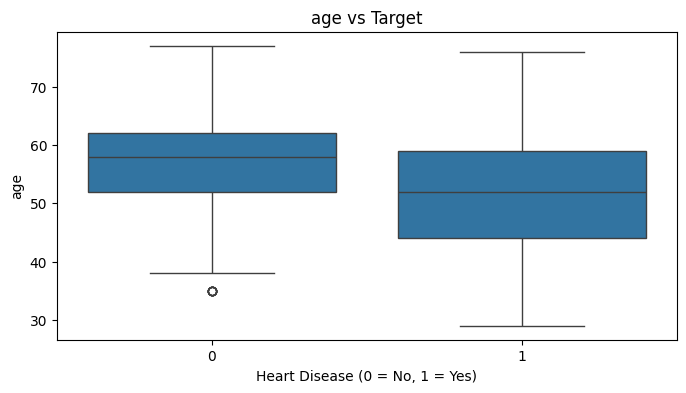

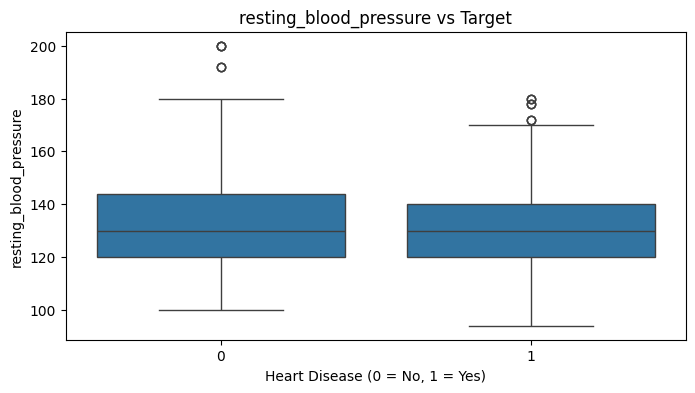

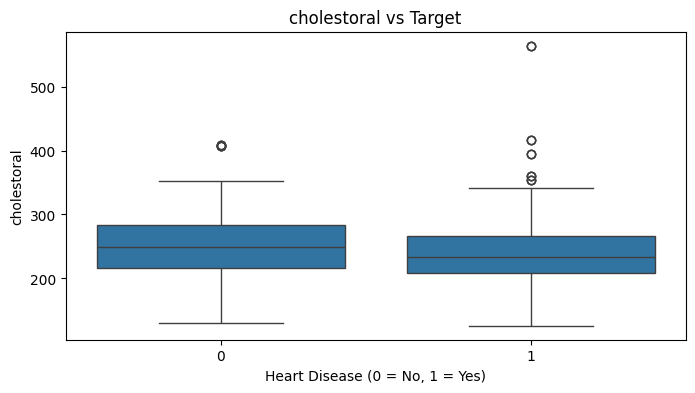

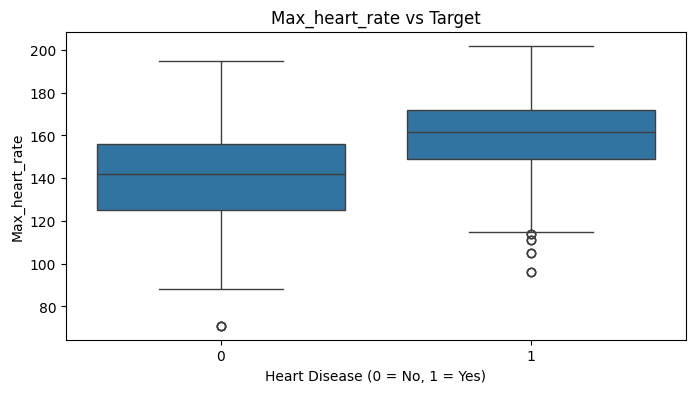

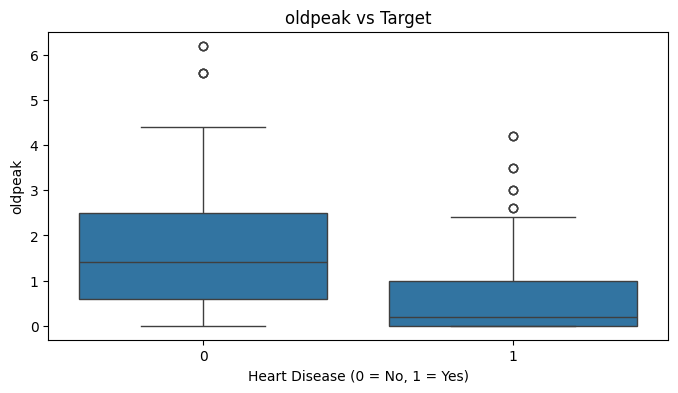

In [18]:
# Relationships Between Features and Target
for column in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='target', y=column, data=data)
    plt.title(f'{column} vs Target')
    plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
    plt.ylabel(column)
    plt.show()

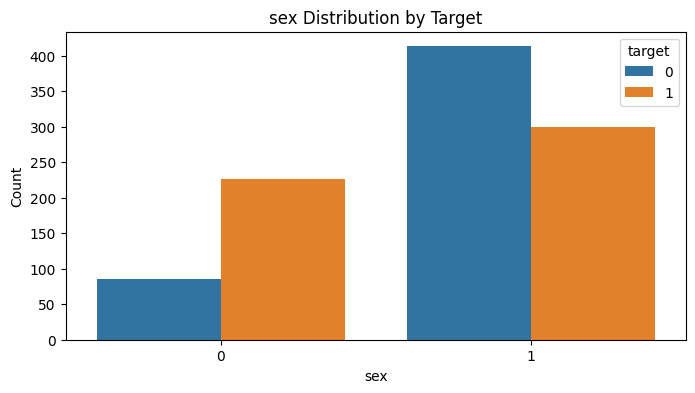

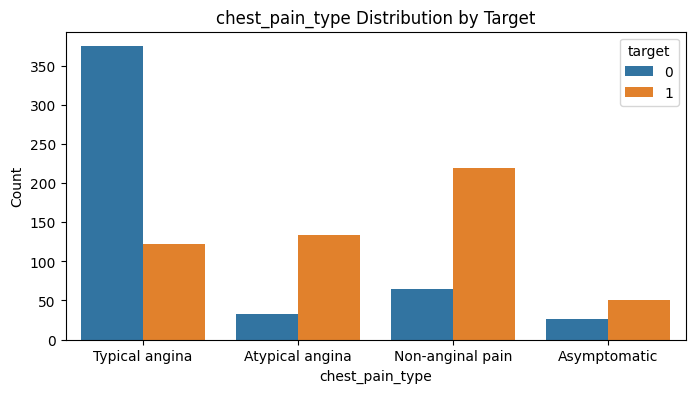

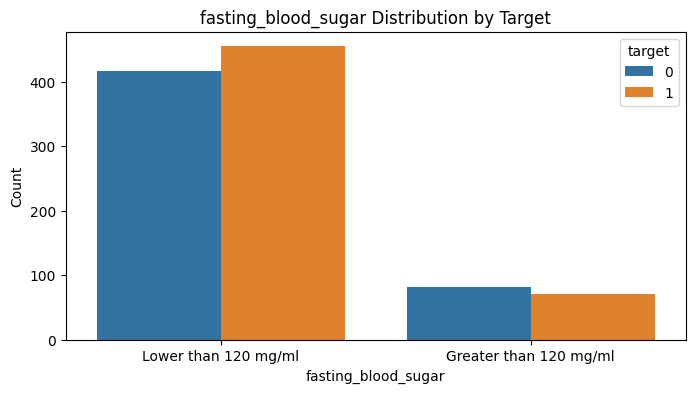

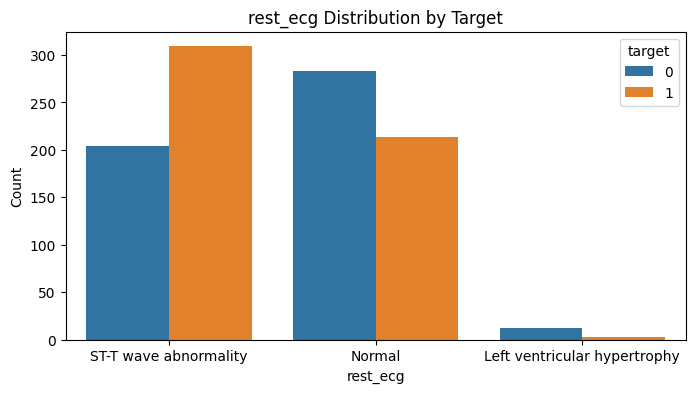

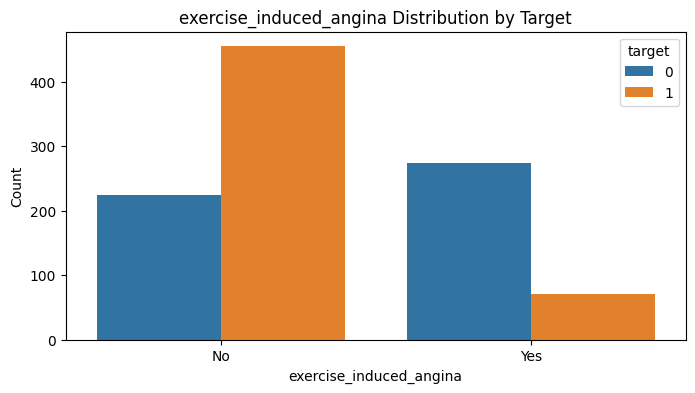

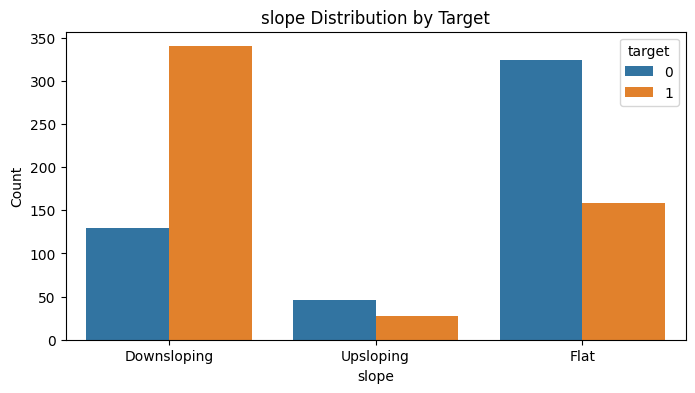

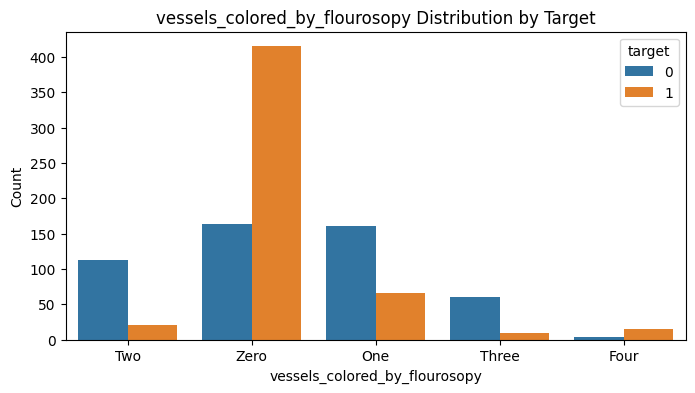

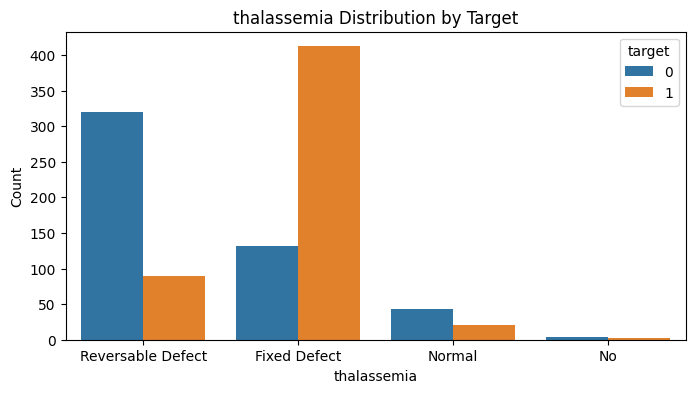

In [19]:
for column in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=column, hue='target', data=data)
    plt.title(f'{column} Distribution by Target')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Machine Learning Model Development

## Baseline Models

In [20]:
log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)

# Train baseline models
log_reg.fit(X_train_preprocessed, y_train)
dec_tree.fit(X_train_preprocessed, y_train)

# Predictions
log_reg_preds = log_reg.predict(X_test_preprocessed)
dec_tree_preds = dec_tree.predict(X_test_preprocessed)



## Evaluate baseline models

In [21]:
print("\nLogistic Regression Performance:")
print(classification_report(y_test, log_reg_preds))




Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       102
           1       0.78      0.89      0.83       103

    accuracy                           0.82       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.83      0.82      0.82       205



In [22]:
print("\nDecision Tree Performance:")
print(classification_report(y_test, dec_tree_preds))


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [23]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation for Baseline Models
models = [log_reg, dec_tree]
model_names = ['Logistic Regression', 'Decision Tree']

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    print(f"\n{name} Cross-Validation Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")



Logistic Regression Cross-Validation Scores: [0.85365854 0.86585366 0.89634146 0.92073171 0.81707317]
Mean Accuracy: 0.8707 (+/- 0.0356)

Decision Tree Cross-Validation Scores: [0.99390244 0.97560976 0.98780488 0.99390244 0.94512195]
Mean Accuracy: 0.9793 (+/- 0.0183)


#  Advanced Models

In [28]:

rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Train advanced models
rf_clf.fit(X_train_preprocessed, y_train)
gb_clf.fit(X_train_preprocessed, y_train)

# Predictions for advanced models
rf_preds = rf_clf.predict(X_test_preprocessed)
gb_preds = gb_clf.predict(X_test_preprocessed)

## Evaluate advanced models

In [29]:
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_preds))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [30]:
print("\nGradient Boosting Performance:")
print(classification_report(y_test, gb_preds))


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       102
           1       0.93      0.95      0.94       103

    accuracy                           0.94       205
   macro avg       0.94      0.94      0.94       205
weighted avg       0.94      0.94      0.94       205



In [31]:
# Cross-validation for Advanced Models
models = [rf_clf, gb_clf]
model_names = ['Random Forest', 'Gradient Boosting']

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    print(f"\n{name} Cross-Validation Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")



Random Forest Cross-Validation Scores: [1.         0.9695122  0.98780488 0.98780488 0.9695122 ]
Mean Accuracy: 0.9829 (+/- 0.0118)

Gradient Boosting Cross-Validation Scores: [0.98780488 0.92073171 0.98170732 0.96341463 0.92682927]
Mean Accuracy: 0.9561 (+/- 0.0276)


# Neural Network Model

In [32]:

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_preprocessed.shape[1], activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=16, validation_data=(X_test_preprocessed, y_test), verbose=1)

c:\Users\Hammad\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6329 - loss: 0.6306 - val_accuracy: 0.7854 - val_loss: 0.4695
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8244 - loss: 0.4211 - val_accuracy: 0.8000 - val_loss: 0.4254
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8689 - loss: 0.3557 - val_accuracy: 0.8146 - val_loss: 0.3937
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.3480 - val_accuracy: 0.8293 - val_loss: 0.3696
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8812 - loss: 0.3324 - val_accuracy: 0.8293 - val_loss: 0.3494
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9102 - loss: 0.2780 - val_accuracy: 0.8439 - val_loss: 0.3503
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8711 - loss: 0.2985 - val_accuracy: 0.8439 - val_loss: 0.3320
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9232 - loss: 0.2265 - val_accuracy: 0.8585 - val_loss

## Evaluate the Neural Network

In [33]:

nn_loss, nn_accuracy = nn_model.evaluate(X_test_preprocessed, y_test, verbose=0)
print("\nNeural Network Performance:")
print(f"Accuracy: {nn_accuracy:.2f}")


Neural Network Performance:
Accuracy: 0.96


# Compare Metrics

In [34]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']
accuracy = [
    accuracy_score(y_test, log_reg_preds),
    accuracy_score(y_test, dec_tree_preds),
    accuracy_score(y_test, rf_preds),
    accuracy_score(y_test, gb_preds),
    nn_accuracy
]

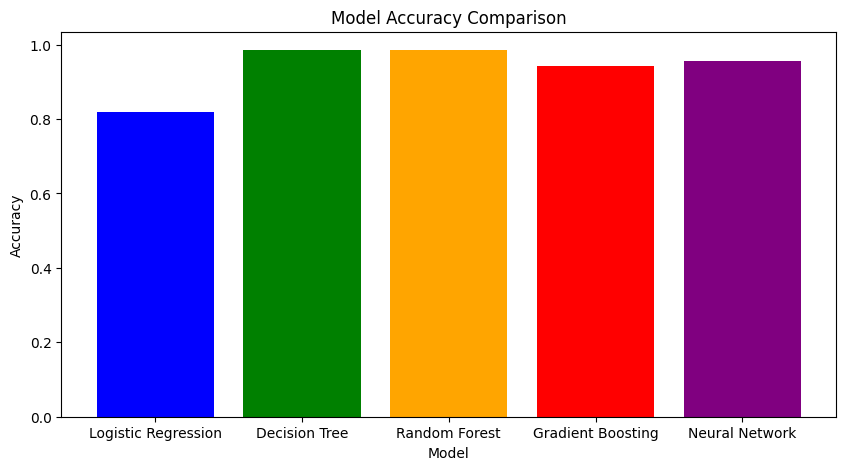

In [35]:
plt.figure(figsize=(10, 5))
plt.bar(models, accuracy, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

## Explainable AI (XAI)  

 It helps in understanding how the Random Forest model makes predictions using SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-Agnostic Explanations).

C:\Users\Hammad\AppData\Local\Temp\ipykernel_2884\3115900945.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


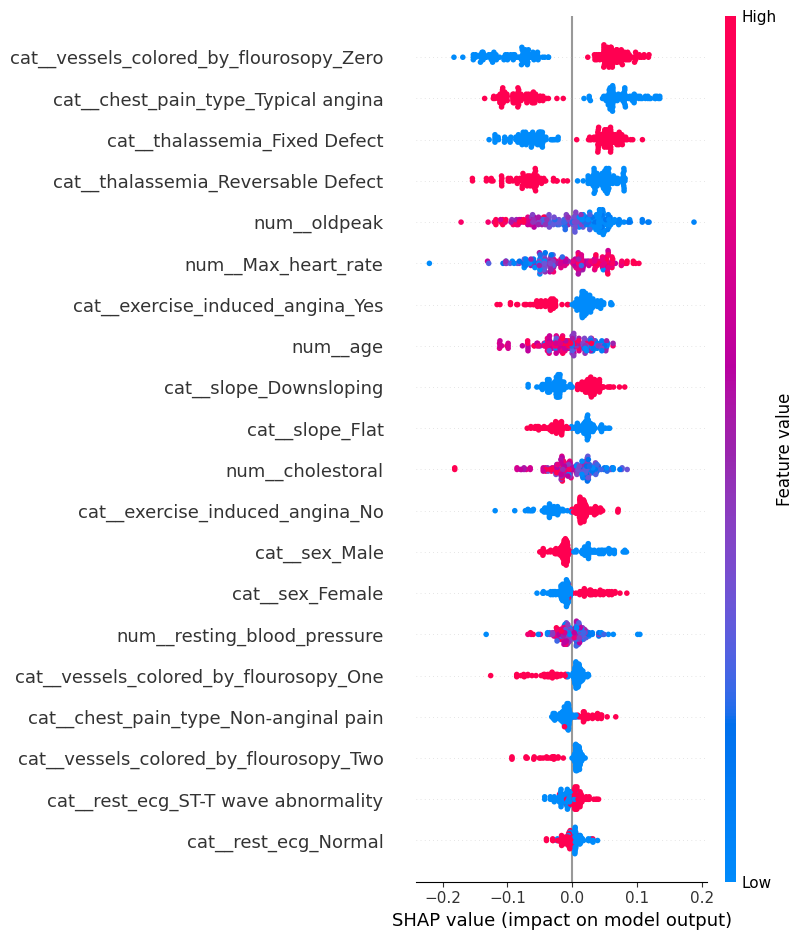

In [44]:

import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

#  Initialize SHAP JavaScript Library
shap.initjs()

# Ensure Preprocessor is Fitted
preprocessor.fit(X_train)  # Fit if not already done

# Get Transformed Feature Names
feature_names_transformed = preprocessor.get_feature_names_out()

# Convert X_test_preprocessed to Pandas DataFrame for easier indexing
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names_transformed)


# Create SHAP Explainer for Tree Models (Random Forest)
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test_preprocessed)

# Ensure Feature Count Matches
if isinstance(shap_values, list):  # For classification models
    shap_values_for_class_1 = np.array(shap_values[1])  # Use class 1 SHAP values
else:
    shap_values_for_class_1 = np.array(shap_values)

# Fix SHAP values if they have an extra dimension
if len(shap_values_for_class_1.shape) == 3:
    shap_values_for_class_1 = shap_values_for_class_1[:, :, 1]  # Select correct class dimension

# Check and fix feature name mismatch
if shap_values_for_class_1.shape[1] != len(feature_names_transformed):
    print("Mismatch Detected: Adjusting feature names!")
    feature_names_transformed = list(feature_names_transformed)[:shap_values_for_class_1.shape[1]]

#  Global Feature Importance Plot
plt.figure(figsize=(12, 16))
shap.summary_plot(shap_values_for_class_1, X_test_preprocessed, feature_names=feature_names_transformed)

# Local Explanation for a Single Prediction
sample_index = 0

# Select expected value for class 1
expected_value = explainer.expected_value[1]  # Use second expected value (for class 1)


force_plot = shap.plots.force(
    expected_value,
    shap_values_for_class_1[sample_index, :], 
    X_test_preprocessed_df.iloc[sample_index] 
)

# Save and display as an interactive HTML file
shap_html = shap.save_html("shap_output.html", force_plot)
display(HTML("shap_output.html"))

# Step 2: LIME Explanations
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed,
    feature_names=feature_names_transformed,  # No need to slice
    class_names=['No Disease', 'Disease'],
    discretize_continuous=True
)


sample_data = X_test_preprocessed_df.iloc[sample_index].values.reshape(1, -1)  
lime_exp = lime_explainer.explain_instance(sample_data[0], rf_clf.predict_proba, num_features=10)  



lime_exp.show_in_notebook()



# Model Evaluation and Performance Metrics

Accuracy: 0.9854
ROC AUC Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



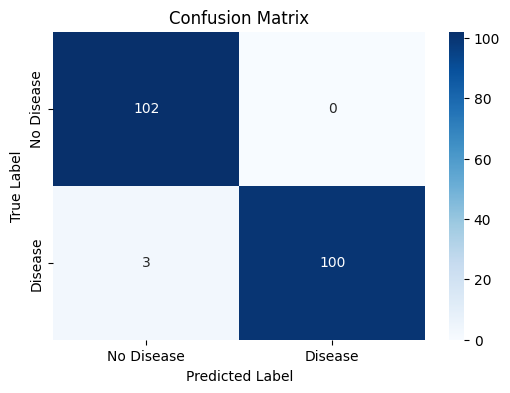

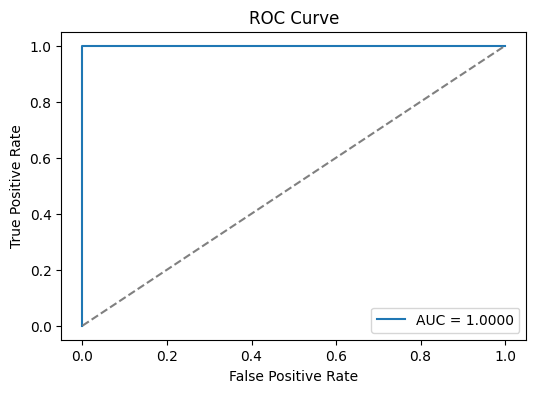

In [36]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Predictions
y_pred = rf_clf.predict(X_test_preprocessed)
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Hyperparameter Tuning Using GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_preprocessed, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9841463414634146


In [38]:
# Evaluate the best model (after GridSearchCV) with cross-validation
best_rf_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_rf_model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
print("\nBest Random Forest Model Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")



Best Random Forest Model Cross-Validation Scores:
[0.99390244 0.9695122  1.         0.98780488 0.9695122 ]
Mean Accuracy: 0.9841 (+/- 0.0126)


# Feature Selection Using Random Forest

In [39]:
from sklearn.feature_selection import SelectFromModel

# Use Random Forest for feature selection
selector = SelectFromModel(rf_clf, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Retrain Model with Selected Features
rf_clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_selected.fit(X_train_selected, y_train)

# Evaluate Performance
y_pred_selected = rf_clf_selected.predict(X_test_selected)
print("\nClassification Report (After Feature Selection):\n", classification_report(y_test, y_pred_selected))



Classification Report (After Feature Selection):
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



## Save the Models

In [42]:
from joblib import dump

# Save the best trained Random Forest model (from GridSearchCV)
dump(grid_search.best_estimator_, "random_forest_model.pkl")

print("✅ Best Model saved as 'random_forest_model.pkl'")


✅ Best Model saved as 'random_forest_model.pkl'


In [45]:
import numpy as np

# Save test dataset (X_test_preprocessed and y_test)
np.save("X_test_preprocessed.npy", X_test_preprocessed)
np.save("y_test.npy", y_test)

# Ensure feature_names_transformed is an array of feature names in correct format
# If you're using a pandas DataFrame, you can get the columns like this:
# feature_names_transformed = X_train_preprocessed.columns.to_list()

# Save feature names
np.save("feature_names.npy", np.array(feature_names_transformed, dtype=object))

print("✅ Test data & feature names saved!")


✅ Test data & feature names saved!


In [49]:
from joblib import dump

# Save the preprocessor pipeline (used during training)
dump(preprocessor, "preprocessor.pkl")

print("✅ Preprocessor saved as 'preprocessor.pkl'")


✅ Preprocessor saved as 'preprocessor.pkl'


In [46]:
!pip install streamlit

# Heart Disease Prediction Web App Using Streamlit  

***This code is only run in web so there is a separate file named dashboard.py is available. Follow the below steps to run this***  
***Open the Command Prompt (or Terminal)***  
Navigate to the directory where your dashboard.py file is saved like (cd C:\Users\Your Name\Desktop\Project)  
Once you're in the correct directory, run the following command:  
***streamlit run dashboard.py***


In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import shap
from joblib import load

# Load trained model & preprocessor
rf_clf = load("random_forest_model.pkl")  # Trained Random Forest model
preprocessor = load("preprocessor.pkl")  # Preprocessing pipeline
feature_names_transformed = np.load("feature_names.npy", allow_pickle=True)  # Feature names

# ------------------------------
#  User Input Section
# ------------------------------
st.subheader("📝 Enter Patient Data for Prediction")

# Define input fields for user
age = st.number_input("Age", min_value=20, max_value=100, value=50)
sex = st.selectbox("Sex", ["Male", "Female"])
chest_pain = st.selectbox("Chest Pain Type", ["Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"])
rest_bp = st.number_input("Resting Blood Pressure (mm Hg)", min_value=80, max_value=200, value=120)
cholestoral = st.number_input("Cholestoral Level (mg/dL)", min_value=100, max_value=500, value=200)
fasting_bs = st.selectbox("Fasting Blood Sugar > 120 mg/dL", ["No", "Yes"])
rest_ecg = st.selectbox("Resting ECG Results", ["Normal", "ST-T wave abnormality", "Left ventricular hypertrophy"])
max_heart_rate = st.number_input("Maximum Heart Rate Achieved", min_value=60, max_value=220, value=150)
exercise_angina = st.selectbox("Exercise-Induced Angina", ["No", "Yes"])
oldpeak = st.number_input("ST Depression (Oldpeak)", min_value=0.0, max_value=10.0, value=1.0)
slope = st.selectbox("Slope of ST Segment", ["Upsloping", "Flat", "Downsloping"])
num_vessels = st.selectbox("Number of Vessels Colored by Fluoroscopy", ["0", "1", "2", "3"])
thalassemia = st.selectbox("Thalassemia", ["Normal", "Fixed Defect", "Reversible Defect"])

# ------------------------------
#  Convert Categorical Inputs
# ------------------------------
sex = 1 if sex == "Male" else 0
chest_pain_mapping = {"Typical Angina": 1, "Atypical Angina": 2, "Non-Anginal Pain": 3, "Asymptomatic": 4}
chest_pain = chest_pain_mapping[chest_pain]
fasting_bs = 1 if fasting_bs == "Yes" else 0
rest_ecg_mapping = {"Normal": 0, "ST-T wave abnormality": 1, "Left ventricular hypertrophy": 2}
rest_ecg = rest_ecg_mapping[rest_ecg]
exercise_angina = 1 if exercise_angina == "Yes" else 0
slope_mapping = {"Upsloping": 1, "Flat": 2, "Downsloping": 3}
slope = slope_mapping[slope]
thal_mapping = {"Normal": 3, "Fixed Defect": 6, "Reversible Defect": 7}
thalassemia = thal_mapping[thalassemia]
num_vessels = int(num_vessels)

# ------------------------------
#  Convert to DataFrame with Correct Column Names
# ------------------------------
original_features = [
    "age", "sex", "chest_pain_type", "resting_blood_pressure", "cholestoral",
    "fasting_blood_sugar", "rest_ecg", "Max_heart_rate", "exercise_induced_angina",
    "oldpeak", "slope", "vessels_colored_by_flourosopy", "thalassemia"
]

user_input = np.array([[age, sex, chest_pain, rest_bp, cholestoral, fasting_bs, rest_ecg, max_heart_rate,
                        exercise_angina, oldpeak, slope, num_vessels, thalassemia]])

user_input_df = pd.DataFrame(user_input, columns=original_features)

# ------------------------------
#  Apply Preprocessing
# ------------------------------
user_input_transformed = preprocessor.transform(user_input_df)

# Convert transformed output back to DataFrame with transformed feature names
user_input_transformed_df = pd.DataFrame(user_input_transformed, columns=feature_names_transformed)

# ------------------------------
#  Prediction Button
# ------------------------------
if st.button("Predict Heart Disease"):
    # Model Prediction
    prediction = rf_clf.predict(user_input_transformed_df)[0]

    # Display Results
    if prediction == 1:
        st.error(f"⚠️ High Risk!")
    else:
        st.success(f"✅ Low Risk!")


# Interactive Heart Disease Prediction Using Jupyter Widgets

In [ ]:
import numpy as np
import pandas as pd
from joblib import load
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Layout, HTML

# Load trained model & preprocessor
rf_clf = load("random_forest_model.pkl")  # Trained Random Forest model
preprocessor = load("preprocessor.pkl")  # Preprocessing pipeline

# ------------------------------
#  Create Title
# ------------------------------
title = HTML("<h1>📝 Enter Patient Data for Prediction</h1>")
display(title)

# ------------------------------
#  Create Input Widgets
# ------------------------------
style = {'description_width': 'initial'}

# Creating input widgets with adjusted layout (more compact)
age_widget = widgets.IntSlider(
    value=50, min=20, max=100, description="Age:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
sex_widget = widgets.RadioButtons(
    options=["Male", "Female"], description="Sex:", style=style,
    layout=Layout(width="80%", margin="5px")
)
chest_pain_widget = widgets.RadioButtons(
    options=["Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"],
    description="Chest Pain:", style=style, layout=Layout(width="80%", margin="5px")
)
rest_bp_widget = widgets.IntSlider(
    value=120, min=80, max=200, description="Rest BP:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
cholestoral_widget = widgets.IntSlider(
    value=200, min=100, max=500, description="Cholestoral:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
fasting_bs_widget = widgets.RadioButtons(
    options=["No", "Yes"], description="Fasting Sugar:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
rest_ecg_widget = widgets.RadioButtons(
    options=["Normal", "ST-T wave abnormality", "Left ventricular hypertrophy"], description="Rest ECG:", 
    style=style, layout=Layout(width="80%", margin="5px")
)
max_hr_widget = widgets.IntSlider(
    value=150, min=60, max=220, description="Max HR:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
exercise_angina_widget = widgets.RadioButtons(
    options=["No", "Yes"], description="Exercise Angina:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
oldpeak_widget = widgets.FloatSlider(
    value=1.0, min=0.0, max=10.0, description="Oldpeak:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
slope_widget = widgets.RadioButtons(
    options=["Upsloping", "Flat", "Downsloping"], description="Slope:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
num_vessels_widget = widgets.Dropdown(
    options=["0", "1", "2", "3"], description="Vessels:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
thal_widget = widgets.RadioButtons(
    options=["Normal", "Fixed Defect", "Reversible Defect"], description="Thalassemia:", style=style, 
    layout=Layout(width="80%", margin="5px")
)

# Button to trigger prediction
predict_button = widgets.Button(
    description="Predict Heart Disease", button_style="success", layout=Layout(width="80%", height="40px", margin="20px")
)

# Output area for displaying prediction result
output = widgets.Output(
    layout=Layout(width="80%", border="solid 2px #ccc", padding="10px", margin="20px")
)

# ------------------------------
#  Handle Prediction Logic
# ------------------------------
def predict_on_click(b):
    with output:
        clear_output()
        
        # Get user input
        age = age_widget.value
        sex = 1 if sex_widget.value == "Male" else 0
        chest_pain_mapping = {"Typical Angina": 1, "Atypical Angina": 2, "Non-Anginal Pain": 3, "Asymptomatic": 4}
        chest_pain = chest_pain_mapping[chest_pain_widget.value]
        rest_bp = rest_bp_widget.value
        cholestoral = cholestoral_widget.value
        fasting_bs = 1 if fasting_bs_widget.value == "Yes" else 0
        rest_ecg_mapping = {"Normal": 0, "ST-T wave abnormality": 1, "Left ventricular hypertrophy": 2}
        rest_ecg = rest_ecg_mapping[rest_ecg_widget.value]
        max_heart_rate = max_hr_widget.value
        exercise_angina = 1 if exercise_angina_widget.value == "Yes" else 0
        oldpeak = oldpeak_widget.value
        slope_mapping = {"Upsloping": 1, "Flat": 2, "Downsloping": 3}
        slope = slope_mapping[slope_widget.value]
        num_vessels = int(num_vessels_widget.value)
        thal_mapping = {"Normal": 3, "Fixed Defect": 6, "Reversible Defect": 7}
        thal = thal_mapping[thal_widget.value]

        # Combine user inputs into a single row
        user_input = np.array([[age, sex, chest_pain, rest_bp, cholestoral, fasting_bs, rest_ecg,
                                max_heart_rate, exercise_angina, oldpeak, slope, num_vessels, thal]])
        original_features = [
            "age", "sex", "chest_pain_type", "resting_blood_pressure", "cholestoral",
            "fasting_blood_sugar", "rest_ecg", "Max_heart_rate", "exercise_induced_angina",
            "oldpeak", "slope", "vessels_colored_by_flourosopy", "thalassemia"
        ]
        user_input_df = pd.DataFrame(user_input, columns=original_features)

        # Preprocess input
        user_input_transformed = preprocessor.transform(user_input_df)

        # Make prediction
        prediction = rf_clf.predict(user_input_transformed)[0]

        # Display result (Only Low Risk or High Risk)
        if prediction == 1:
            display(HTML("<h3 style='color:red;'>⚠️ High Risk of Heart Disease!</h3>"))
        else:
            display(HTML("<h3 style='color:green;'>✅ Low Risk of Heart Disease!</h3>"))

# Attach the button click handler
predict_button.on_click(predict_on_click)

# ------------------------------
# Organize Widgets Layout
# ------------------------------
input_widgets = widgets.VBox([
    age_widget, sex_widget, chest_pain_widget, rest_bp_widget, cholestoral_widget, fasting_bs_widget,
    rest_ecg_widget, max_hr_widget, exercise_angina_widget, oldpeak_widget, slope_widget, num_vessels_widget,
    thal_widget
], layout=Layout(width="80%", margin="20px"))

# Create a VBox layout for the button and output
button_and_output = widgets.VBox([predict_button, output], layout=Layout(width="80%", margin="20px"))

# Display the widgets
display(input_widgets, button_and_output)


HTML(value='<h1>📝 Enter Patient Data for Prediction</h1>')